The aim of this project is to prepare a Data Pipeline using the ETL method. The end user suppose to find in the data warehouse the data for the analysis that he needs to implement.

The data source are different csv files, which include data from Airbnb listings for 6 different capitals in Europe. The files have been taken by kaggle, https://www.kaggle.com/datasets/thedevastator/airbnb-price-determinants-in-europe . Additionally, I use the geojson files with the names of each city's neighbourhoods, in order to know the neighbourhood of each Airbnb listing.

The loaded data will include the Price, the Housing type (Home or Private room), Capacity, Cleanless, Satisfaction, Bedrooms, Attractiveness, Longitude, Latitude, City and Neighbourhood.

Let's see the workflow.

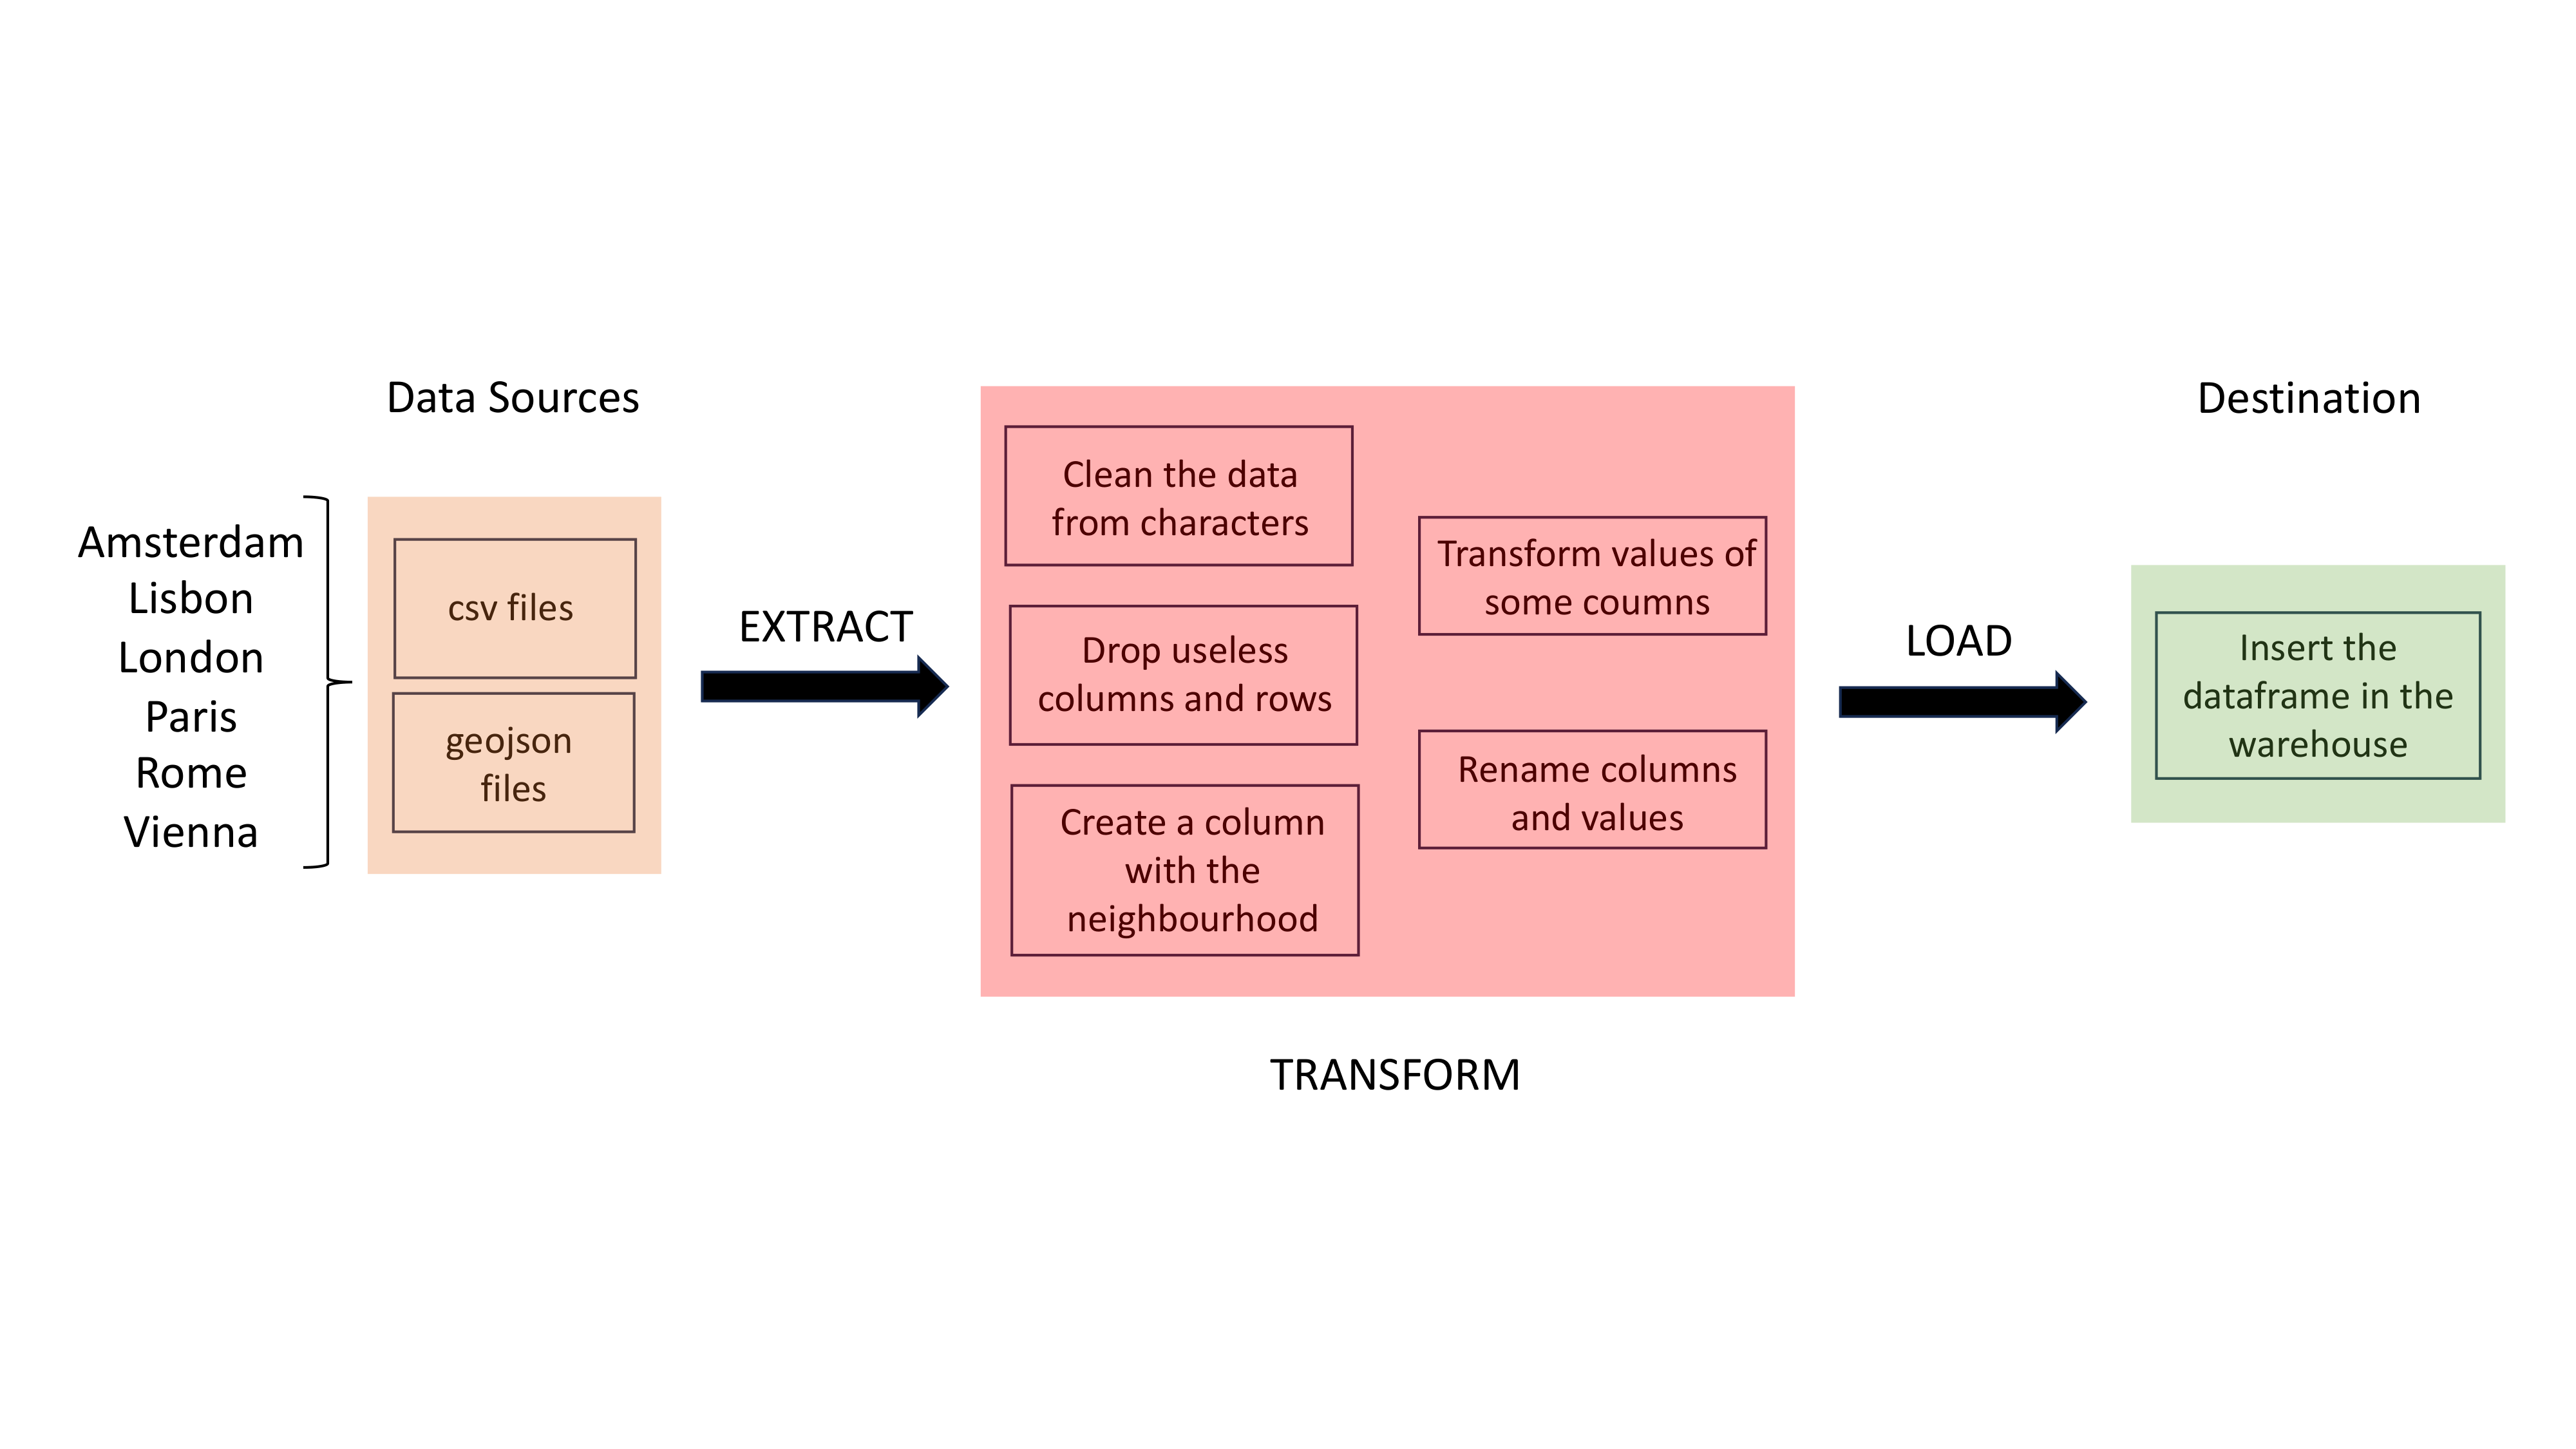

In [1]:
from IPython.display import Image
Image(filename='ETL_pyspark.png')

Initialize the findspark

In [2]:
import findspark

findspark.find()
findspark.init()

Create the objects sc and spark

In [3]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession

sc = SparkContext.getOrCreate()

spark = SparkSession.builder\
                    .master('local')\
                    .appName('Airbnb')\
                    .getOrCreate()

# EXTRACT

Let's find the csv files and put them in a list. Let's do the same for the cities.

In [4]:
import glob
csv_files = glob.glob('*.csv')


# identify the names of the cities 
cities = []
for file in csv_files:
    cities.append(file[:-4])

Check the csv files

In [5]:
csv_files

['Amsterdam.csv',
 'Vienna.csv',
 'Rome.csv',
 'Lisbon.csv',
 'Paris.csv',
 'London.csv']

First of all, I read the very first csv file and I add a column with the city name that respects to this file. Secondly, I read the other csv files in a loop, add the respective city in a column and then append the file to the first object.

In [6]:
from pyspark.sql.functions import lit

data = spark.read.csv(csv_files[0], header=True)

data = data.withColumn("City",lit(cities[0]))

for file, city in zip(csv_files,cities):
    df = spark.read.csv(file, header=True)
    df = df.withColumn("City",lit(city))
    data = data.union(df)
    
data.show(2)

+---+------------------+------------+-----------+------------+---------------+-----------------+-----+---+------------------+--------------------------+--------+------------------+-------------------+-----------------+------------------+-----------------+-----------------+-------+------------------+---------+
|_c0|           realSum|   room_type|room_shared|room_private|person_capacity|host_is_superhost|multi|biz|cleanliness_rating|guest_satisfaction_overall|bedrooms|              dist|         metro_dist|       attr_index|   attr_index_norm|       rest_index|  rest_index_norm|    lng|               lat|     City|
+---+------------------+------------+-----------+------------+---------------+-----------------+-----+---+------------------+--------------------------+--------+------------------+-------------------+-----------------+------------------+-----------------+-----------------+-------+------------------+---------+
|  0|194.03369812293488|Private room|      False|        True|     

In [7]:
data.count()

19037

I must also read the geojson files, in order to take information about the neighbourhoods.

In [8]:
import geopandas

geojson_files = glob.glob('*.geojson')

nbh_geo = {}
for file in geojson_files:
    read_file = geopandas.read_file(file, driver='GeoJSON')
    read_file = read_file.rename({"neighbourhood":"Neighbourhood"}, axis=1)
    read_file = read_file.drop("neighbourhood_group", axis=1)
    city = file[:-23]
    nbh_geo[city] = read_file

/Users/antonis1991/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
<ipython-input-8-92c4debed647>:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migratio

# TRANSFORM

Drop columns that I do not need

In [9]:
cols = ("_c0","room_shared","room_private","host_is_superhost","multi","biz",
        "rest_index_norm","dist","metro_dist","attr_index","rest_index")

data = data.drop(*cols)

In [10]:
data.show(2)

+------------------+------------+---------------+------------------+--------------------------+--------+------------------+-------+------------------+---------+
|           realSum|   room_type|person_capacity|cleanliness_rating|guest_satisfaction_overall|bedrooms|   attr_index_norm|    lng|               lat|     City|
+------------------+------------+---------------+------------------+--------------------------+--------+------------------+-------+------------------+---------+
|194.03369812293488|Private room|            2.0|              10.0|                      93.0|       1| 4.166707868490748|4.90569|          52.41772|Amsterdam|
| 344.2457760176224|Private room|            4.0|               8.0|                      85.0|       1|33.421208615275404|4.90005|52.374320000000004|Amsterdam|
+------------------+------------+---------------+------------------+--------------------------+--------+------------------+-------+------------------+---------+
only showing top 2 rows



Rename some columns

In [11]:
data = data.withColumnRenamed("realSum","Price") \
           .withColumnRenamed("room_type","Housing") \
           .withColumnRenamed("person_capacity","Capacity") \
           .withColumnRenamed("bedrooms","Bedrooms") \
           .withColumnRenamed("cleanliness_rating","Cleanless") \
           .withColumnRenamed("guest_satisfaction_overall","Satisfaction") \
           .withColumnRenamed("attr_index_norm","Attractiveness") \
           .withColumnRenamed("lng","Longitude") \
           .withColumnRenamed("lat","Latitude")

In [12]:
data.show(2)

+------------------+------------+--------+---------+------------+--------+------------------+---------+------------------+---------+
|             Price|     Housing|Capacity|Cleanless|Satisfaction|Bedrooms|    Attractiveness|Longitude|          Latitude|     City|
+------------------+------------+--------+---------+------------+--------+------------------+---------+------------------+---------+
|194.03369812293488|Private room|     2.0|     10.0|        93.0|       1| 4.166707868490748|  4.90569|          52.41772|Amsterdam|
| 344.2457760176224|Private room|     4.0|      8.0|        85.0|       1|33.421208615275404|  4.90005|52.374320000000004|Amsterdam|
+------------------+------------+--------+---------+------------+--------+------------------+---------+------------------+---------+
only showing top 2 rows



Keep specific decimals for specific columns

In [13]:
from pyspark.sql.functions import col, round

cols_convert_to_int = ["Capacity","Cleanless","Satisfaction"]
for col_name in cols_convert_to_int:
    data = data.withColumn(col_name, col(col_name).cast('int'))

    
cols_keep_2_decimals = ["Price","Attractiveness"]
for col_name in cols_keep_2_decimals:
    data = data.withColumn(col_name, round(data[col_name],2))


cols_keep_4_decimals = ["Longitude","Latitude"]
for col_name in cols_keep_4_decimals:
    data = data.withColumn(col_name, round(data[col_name],4))

In [14]:
data.show(5)

+------+------------+--------+---------+------------+--------+--------------+---------+--------+---------+
| Price|     Housing|Capacity|Cleanless|Satisfaction|Bedrooms|Attractiveness|Longitude|Latitude|     City|
+------+------------+--------+---------+------------+--------+--------------+---------+--------+---------+
|194.03|Private room|       2|       10|          93|       1|          4.17|   4.9057| 52.4177|Amsterdam|
|344.25|Private room|       4|        8|          85|       1|         33.42|   4.9001| 52.3743|Amsterdam|
| 264.1|Private room|       2|        9|          87|       1|          3.99|   4.9751|  52.361|Amsterdam|
|433.53|Private room|       4|        9|          90|       2|         26.12|   4.8942| 52.3766|Amsterdam|
|485.55|Private room|       2|       10|          98|       1|         29.27|   4.9005| 52.3751|Amsterdam|
+------+------------+--------+---------+------------+--------+--------------+---------+--------+---------+
only showing top 5 rows



I know that Housing has three values, Private room - Entire home/apt - Shared room. The last option occupies a small percentage in the dataset. I will drop the respective rows. Before I drop off the respective rows, Let's see how many are there.

In [15]:
data.groupBy("Housing").count().orderBy("count").show()

+---------------+-----+
|        Housing|count|
+---------------+-----+
|    Shared room|  131|
|   Private room| 7508|
|Entire home/apt|11398|
+---------------+-----+



Keep only the rows that do not include the Shared room option.

In [16]:
data = data.filter(data.Housing!="Shared room")

Let's check it

In [17]:
data.groupBy("Housing").count().orderBy("count").show()

+---------------+-----+
|        Housing|count|
+---------------+-----+
|   Private room| 7508|
|Entire home/apt|11398|
+---------------+-----+



I replace values in the Housing column.

In [18]:
from pyspark.sql.functions import regexp_replace

data = data.withColumn('Housing', regexp_replace('Housing', 'Entire home/apt', 'Home')) \
           .withColumn('Housing', regexp_replace('Housing', 'Private room', 'Single room'))

data.show(2)

+------+-----------+--------+---------+------------+--------+--------------+---------+--------+---------+
| Price|    Housing|Capacity|Cleanless|Satisfaction|Bedrooms|Attractiveness|Longitude|Latitude|     City|
+------+-----------+--------+---------+------------+--------+--------------+---------+--------+---------+
|194.03|Single room|       2|       10|          93|       1|          4.17|   4.9057| 52.4177|Amsterdam|
|344.25|Single room|       4|        8|          85|       1|         33.42|   4.9001| 52.3743|Amsterdam|
+------+-----------+--------+---------+------------+--------+--------------+---------+--------+---------+
only showing top 2 rows



In this stage, I must transform the data related to the geojson files. I need to correct typos for Vienna's neighbourhoods.

In [19]:
for i in range(nbh_geo["Vienna"].shape[0]):
    if nbh_geo["Vienna"].iloc[i,0]=='Rudolfsheim-Fnfhaus':
        nbh_geo["Vienna"].iloc[i,0]='Rudolfsheim-Fünfhaus'
    elif nbh_geo["Vienna"].iloc[i,0]=='Landstra§e':
        nbh_geo["Vienna"].iloc[i,0]='Landstrasse'
    elif nbh_geo["Vienna"].iloc[i,0]=='Whring':
        nbh_geo["Vienna"].iloc[i,0]='Währing'
    elif nbh_geo["Vienna"].iloc[i,0]=='Dbling':
        nbh_geo["Vienna"].iloc[i,0]='Döbling'

Spark is not compatible with geojson. Thus, I need to isolate the Longitude, Latitude and the City from my pyspark dataframe, convert them to pandas and continue working.

In [20]:
lng_lat_city = data.select(["Longitude","Latitude","City"]).toPandas()
lng_lat_city.head()

,Longitude,Latitude,City
0,4.9057,52.4177,Amsterdam
1,4.9001,52.3743,Amsterdam
2,4.9751,52.3610,Amsterdam
3,4.8942,52.3766,Amsterdam
4,4.9005,52.3751,Amsterdam


I need to find for each Airbnb listing (Longitude,Latitude), the neighbourhood that they belong to. For this I use the Point function from the shapely library.

In [21]:
from shapely.geometry import Point

neighbourhoods = []
for city in cities:
    
    geo_file = nbh_geo[city]
    
    dataset=lng_lat_city[lng_lat_city.City==city]
    dataset = dataset.reset_index()
    city_length = dataset.shape[0]
    boroughs = [''] * city_length
    
    for i in range(city_length):
        j=0
        while j<len(geo_file.geometry.values):   
            specific_point = Point(dataset["Longitude"][i],dataset["Latitude"][i])
            neighbourhood = geo_file.geometry.values[j]
            if specific_point.within(neighbourhood):
                boroughs[i] = geo_file.Neighbourhood[j]
                break
            j+=1
    neighbourhoods.append(boroughs)

I add the neighbourhoods as a column to the pandas dataframe.

In [22]:
lng_lat_city["Neighbourhood"] = [borough for sublist in neighbourhoods for borough in sublist]

I drop off the Longitude and Latitude from the pandas dataframe.

In [23]:
# Drop the Longitude and Latitude
lng_lat_city = lng_lat_city.drop(["Longitude","Latitude"], axis=1)

# Convert the pandas dataframe to spark dataframe
lng_lat_city = spark.createDataFrame(lng_lat_city)
lng_lat_city.show(4)

+---------+--------------------+
|     City|       Neighbourhood|
+---------+--------------------+
|Amsterdam|          Noord-West|
|Amsterdam|        Centrum-West|
|Amsterdam|IJburg - Zeeburge...|
|Amsterdam|        Centrum-West|
+---------+--------------------+
only showing top 4 rows



In this stage I must add the Neighbourhoods that I found in the pyspark dataframe.

In [24]:
from pyspark.sql import functions as F
from pyspark.sql.types import StringType
from pyspark.sql.functions import row_number, monotonically_increasing_id
from pyspark.sql.window import Window


labels_udf = F.udf(lambda indx: neighbourhoods[indx-1], StringType())

neighbourhoods = lng_lat_city.rdd.map(lambda x: x[1]).collect()

# Create a column with continuous increasing Id's
data = data.withColumn("num_id", row_number().over(Window.orderBy(monotonically_increasing_id())))

# Create a new column by calling the user defined function
data = data.withColumn('Neighbourhood', labels_udf('num_id'))
  
# Delete the increasing Id's column
data = data.drop('num_id')

In [25]:
data.show(2)

+------+-----------+--------+---------+------------+--------+--------------+---------+--------+---------+-------------+
| Price|    Housing|Capacity|Cleanless|Satisfaction|Bedrooms|Attractiveness|Longitude|Latitude|     City|Neighbourhood|
+------+-----------+--------+---------+------------+--------+--------------+---------+--------+---------+-------------+
|194.03|Single room|       2|       10|          93|       1|          4.17|   4.9057| 52.4177|Amsterdam|   Noord-West|
|344.25|Single room|       4|        8|          85|       1|         33.42|   4.9001| 52.3743|Amsterdam| Centrum-West|
+------+-----------+--------+---------+------------+--------+--------------+---------+--------+---------+-------------+
only showing top 2 rows



I check for missing values.

In [26]:
from pyspark.sql.functions import isnan,when,count

df2 = data.select([count(when(col(c).contains('None') | \
                              col(c).contains('NULL') | \
                              (col(c) == "" ) | \
                              col(c).isNull() | \
                              isnan(c), c )).alias(c) for c in data.columns])
df2.show()

+-----+-------+--------+---------+------------+--------+--------------+---------+--------+----+-------------+
|Price|Housing|Capacity|Cleanless|Satisfaction|Bedrooms|Attractiveness|Longitude|Latitude|City|Neighbourhood|
+-----+-------+--------+---------+------------+--------+--------------+---------+--------+----+-------------+
|    0|      0|       0|        0|           0|       0|             0|        0|       0|   0|           26|
+-----+-------+--------+---------+------------+--------+--------------+---------+--------+----+-------------+



I drop the missing values from the dataset.

In [27]:
data = data.filter(data.Neighbourhood!="")

Check again if the missing values have been dropped off.

In [28]:
df2 = data.select([count(when(col(c).contains('None') | \
                              col(c).contains('NULL') | \
                              (col(c) == "" ) | \
                              col(c).isNull() | \
                              isnan(c), c )).alias(c) for c in data.columns])
df2.show()

+-----+-------+--------+---------+------------+--------+--------------+---------+--------+----+-------------+
|Price|Housing|Capacity|Cleanless|Satisfaction|Bedrooms|Attractiveness|Longitude|Latitude|City|Neighbourhood|
+-----+-------+--------+---------+------------+--------+--------------+---------+--------+----+-------------+
|    0|      0|       0|        0|           0|       0|             0|        0|       0|   0|            0|
+-----+-------+--------+---------+------------+--------+--------------+---------+--------+----+-------------+



# LOAD

This is the last stage and the dataset have to be loaded to the spark-warehouse.

Firstly, I initialize the object.

In [29]:
from os.path import abspath

warehouse_location = abspath('spark-warehouse')

spark2 = SparkSession \
    .builder \
    .appName("Python Spark SQL Hive integration") \
    .config("spark.sql.warehouse.dir", warehouse_location) \
    .enableHiveSupport() \
    .getOrCreate()

I create a database with the name Airbnb_prices.

In [30]:
spark2.sql("CREATE DATABASE IF NOT EXISTS Airbnb_prices")

DataFrame[]

In [31]:
spark2.sql('show databases').show()

+-------------+
|    namespace|
+-------------+
|airbnb_prices|
|      default|
+-------------+



I load the data in the database as table with the name Price_per_city.

In [32]:
data.write.mode("overwrite").saveAsTable("Airbnb_prices.Prices_per_city")

I check what is included in the database.

In [33]:
spark2.sql("Show tables from Airbnb_prices;").show()

+-------------+---------------+-----------+
|    namespace|      tableName|isTemporary|
+-------------+---------------+-----------+
|airbnb_prices|prices_per_city|      false|
+-------------+---------------+-----------+

